In [0]:
# Load the Drive helper and mount
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd
%cd /content/drive/My Drive/Term5/NLP/Project

/content
/content/drive/My Drive/Term5/NLP/Project


In [0]:
import pandas as pd
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
def readFile(fileName):
  filedata = pd.read_csv(fileName, delimiter='\t', header = None, skiprows=1)
  filedata.columns = ["id", "drugName", "condition", "review", "rating", "date", "usefulCount", "clean_review", "sentiment"]
  filedata.drop(['review'], axis=1, inplace = True)
  filedata.dropna(axis=0, inplace=True)
  return filedata

In [0]:
dataPath = '/content/drive/My Drive/Term5/NLP/Project/Dataset'
outputPath = '/content/drive/My Drive/Term5/NLP/Project/Model_output/GRU/'
glove_vectors_file = dataPath + '/../word_embeddings/glove.840B.300d.txt'

In [0]:
drug_train = dataPath + '/cleaned_Train_data.csv'
drug_test = dataPath + '/cleaned_Test_data.csv'
drug_valid = dataPath + '/cleaned_Valid_data.csv'

In [0]:
train_data = readFile(drug_train)
valid_data = readFile(drug_valid)
test_data = readFile(drug_test)

In [0]:
train_data.head(3)

,id,drugName,condition,rating,date,usefulCount,clean_review,sentiment
0,204048,Xerac AC,Hyperhidrosis,10.0,"May 15, 2010",10,wow struggl excess underarm sweat sever year r...,1
1,52764,Carbidopa / levodopa,Parkinson's Disease,4.0,"December 30, 2016",17,rytari month first work well pill mg mg time d...,0
2,210591,Mirtazapine,Post Traumatic Stress Disorde,7.0,"September 1, 2017",6,hey least one make manic suicid like zoloft pr...,1


In [0]:
import io
import numpy as np

In [0]:
#http://nlp.stanford.edu/data/glove.840B.300d.zip
glove_embeddings = {}

print('Loading '+ glove_vectors_file)
with open(glove_vectors_file, 'r') as f:
  for line in f:
    values = line.split(' ')
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = embedding
        
print('Embeddings size: %d' % len(glove_embeddings))

Loading /content/drive/My Drive/Term5/NLP/Project/Dataset/../word_embeddings/glove.840B.300d.txt
Embeddings size: 2196016


In [0]:
embedding_dim = 300

In [0]:
def convertSentencesToList(traindata, validdata):
  train_sentence = traindata['clean_review'].values.tolist()
  valid_sentence = validdata['clean_review'].values.tolist()
  return train_sentence, valid_sentence

In [0]:
def converToWordSequences(embeddinglength, training_data, t_s, v_s):
  tokenizer = Tokenizer(num_words = embeddinglength)
  tokenizer.fit_on_texts(training_data)

  t_s_word_sequences = tokenizer.texts_to_sequences(t_s)

  v_s_word_sequences = tokenizer.texts_to_sequences(v_s)
  return tokenizer, t_s_word_sequences, v_s_word_sequences

In [0]:
train_sent, valid_sent = convertSentencesToList(train_data, valid_data)

In [0]:
glove_length = len(glove_embeddings)

print('Found '+ str(len(train_sent)) + ' in training sentence')

training_sent = train_sent
valid_sent = valid_sent

tokenizer_g, t_s_word_sequences_g, v_s_word_sequences_g = converToWordSequences(glove_length, training_sent, train_sent, valid_sent)
word_index_g = tokenizer_g.word_index

print('Found '+str(len(word_index_g))+' unique tokens for glove sequencing.')

Found 127122 in training sentence
Found 29822 unique tokens for glove sequencing.


In [0]:
from collections import defaultdict

In [0]:
def useWordEmbeddings(word_index, NUM_WORDS, embeddings, sentence_word_sequences):
  words_len = min(NUM_WORDS, len(word_index))
  # word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))
  word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
  k = 0
  for word, i in word_index.items():
    if i >= NUM_WORDS:
      continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      word_embedding_matrix[i] = embedding_vector
      k += 1

  return word_embedding_matrix

In [0]:
word_embedding_matrix_g = useWordEmbeddings(word_index_g, glove_length, glove_embeddings, t_s_word_sequences_g)

In [0]:
max_seq_length = 300

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
def convertToPadSequences(sentence_word_sequences, valid_sentence_word_sequences, max_seq_length):
  s1_data = pad_sequences(sentence_word_sequences, maxlen = max_seq_length)
  s1_dataValid = pad_sequences(valid_sentence_word_sequences, maxlen = max_seq_length)
  return s1_data, s1_dataValid

In [0]:
def printSentenceInfo(s1_data, labels):
  print('Shape of sentence1 tensor:', s1_data.shape)
  print('Shape of label tensor:', labels.shape)

In [0]:
s1_data_g, s1_dataValid_g = convertToPadSequences(t_s_word_sequences_g, v_s_word_sequences_g, max_seq_length)

In [0]:
from keras.utils import np_utils, plot_model
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [0]:
def convertToCategorical(data):
  labels = np_utils.to_categorical(le.fit_transform(data["sentiment"].values)).astype("int64")
  return labels

In [0]:
train_labels = convertToCategorical(train_data)
valid_labels = convertToCategorical(valid_data)

In [0]:
printSentenceInfo(s1_data_g, train_labels)

Shape of sentence1 tensor: (127122, 300)
Shape of label tensor: (127122, 2)


In [0]:
from keras.layers import Embedding, concatenate, Dense, PReLU, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, GRU
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from IPython.display import Image
import time
import matplotlib.pyplot as plt

In [0]:
num_rnn = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_rnn = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [0]:
batch_size = 128

In [0]:
def trainModel(model, model_name, s1_data, labels, batch_size, s1_data_valid, labels_valid):
  checkpoint = ModelCheckpoint(outputPath+ model_name + '-checkpoint-weights.{epoch:02d}-{val_accuracy:.2f}.hdf5', monitor='val_accuracy', save_best_only=True)
  history = model.fit([s1_data],
                        labels,
                        epochs = 10,
                        batch_size = batch_size,
                        validation_data=([s1_data_valid], labels_valid),
                        shuffle = False,
                        verbose = 2,
                        callbacks = [checkpoint])
  return history

In [0]:
def plotModelPicture(model, model_name):
  plot_model(model, to_file = outputPath + model_name + '-model.png', show_shapes=False)

In [0]:
def plotMetricsGraph(modelhistory, model_name):
  # summarize history for accuracy
  plt.plot(modelhistory.history['accuracy'])
  plt.plot(modelhistory.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  plt.savefig(model_name + '-acc.png', dpi = 300)

  # summarize history for loss
  plt.plot(modelhistory.history['loss'])
  plt.plot(modelhistory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  plt.savefig(model_name + '-loss.png', dpi = 300)

In [0]:
def evaluateModel(model, test_s_data, test_labels):
  loss, accuracy = model.evaluate([test_s_data], test_labels)
  print('loss     = ', loss)
  print('accuracy = ', accuracy)

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plotConfusionMatrix(test_y, y_pred):
  #y_pred=model.predict(test_x,batch_size=15)
  #cm =confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
  cm =confusion_matrix(test_y, y_pred)
  print(cm)
  index = ['Negative','Positive']
  columns = ['Negative','Positive']
  cm_df = pd.DataFrame(cm,columns,index)             
  plt.figure(figsize=(10,6))
  sns.heatmap(cm_df, annot=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def GRUModel(word_index, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH, p_drop=0.0):
  encoder_1 = Sequential()
  encoder_1.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False))
  
  encoder_1.add(GRU(64,dropout=0.4,return_sequences=True))
  encoder_1.add(GRU(32,dropout=0.5,return_sequences=False))
  encoder_1.add(Dense(2,activation='sigmoid'))
  encoder_1.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.001),metrics=['accuracy'])
  return encoder_1

In [0]:
model_gru_g = GRUModel(word_index_g, embedding_dim, word_embedding_matrix_g, max_seq_length, p_drop=0.25)
model_gru_g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          8946900   
_________________________________________________________________
gru_1 (GRU)                  (None, 300, 64)           70080     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 9,026,358
Trainable params: 79,458
Non-trainable params: 8,946,900
_________________________________________________________________


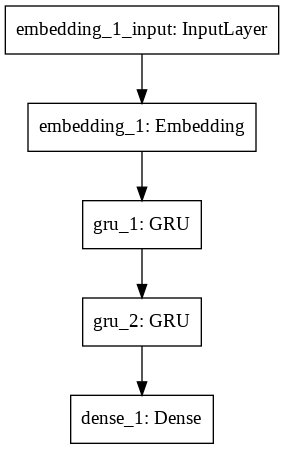

In [0]:
model_name = 'GRU_Glove'
plotModelPicture(model_gru_g, model_name)
Image(filename = outputPath + model_name + '-model.png')

In [0]:
history_gru_g = trainModel(model_gru_g, model_name, s1_data_g, train_labels, batch_size, s1_dataValid_g, valid_labels)

Train on 127122 samples, validate on 31607 samples
Epoch 1/10
 - 1020s - loss: 0.4964 - accuracy: 0.7626 - val_loss: 0.4276 - val_accuracy: 0.8114
Epoch 2/10
 - 1019s - loss: 0.4242 - accuracy: 0.8071 - val_loss: 0.4031 - val_accuracy: 0.8280
Epoch 3/10
 - 1003s - loss: 0.3964 - accuracy: 0.8221 - val_loss: 0.3702 - val_accuracy: 0.8373
Epoch 4/10
 - 1014s - loss: 0.3815 - accuracy: 0.8301 - val_loss: 0.3604 - val_accuracy: 0.8451
Epoch 5/10
 - 1009s - loss: 0.3687 - accuracy: 0.8376 - val_loss: 0.3444 - val_accuracy: 0.8511
Epoch 6/10
 - 1006s - loss: 0.3585 - accuracy: 0.8422 - val_loss: 0.3390 - val_accuracy: 0.8544
Epoch 7/10
 - 1009s - loss: 0.3513 - accuracy: 0.8454 - val_loss: 0.3362 - val_accuracy: 0.8552
Epoch 8/10
 - 1010s - loss: 0.3459 - accuracy: 0.8497 - val_loss: 0.3262 - val_accuracy: 0.8593
Epoch 9/10
 - 1016s - loss: 0.3400 - accuracy: 0.8522 - val_loss: 0.3272 - val_accuracy: 0.8603
Epoch 10/10
 - 1028s - loss: 0.3348 - accuracy: 0.8547 - val_loss: 0.3217 - val_accur

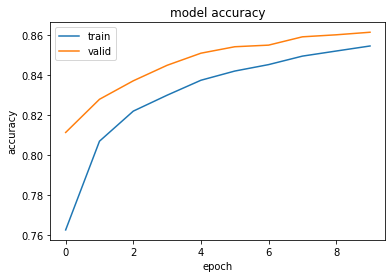

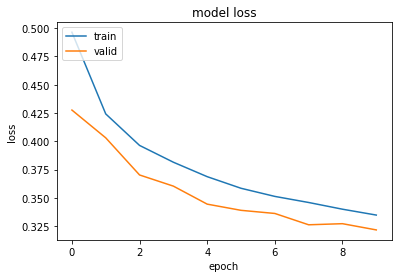

<Figure size 432x288 with 0 Axes>

In [0]:
plotMetricsGraph(history_gru_g, model_name)

In [0]:
def getTestDataSequences(tokenizer):
  test_s_word_sequences = tokenizer.texts_to_sequences(test_data['clean_review'].values.tolist())

  test_s_data = pad_sequences(test_s_word_sequences, maxlen = max_seq_length)
  test_labels = np_utils.to_categorical(le.fit_transform(test_data["sentiment"].values)).astype("int64")

  print('Shape of test sentence1 tensor:', test_s_data.shape)
  print('Shape of test label tensor:', test_labels.shape)
  return test_s_data, test_labels

In [0]:
test_s_data_g, test_labels_g = getTestDataSequences(tokenizer_g)

Shape of test sentence1 tensor: (52856, 300)
Shape of test label tensor: (52856, 2)


In [0]:
evaluateModel(model_gru_g, test_s_data_g, test_labels_g)

52856/52856 [==============================] - 147s 3ms/step
loss     =  0.32220633674609744
accuracy =  0.8632605671882629


In [0]:
model = model_gru_g

In [0]:
test_pred = model.predict([test_s_data_g], batch_size=32)

In [0]:
output = list()
output_score = list()
for x in test_pred:
  #print(type(x))
  output_score.append(np.amax(x))
  output.append(np.argmax(x))

test_data["Actual Output"] = output
test_data["Predicted Score"] = output_score

test_data.to_excel(outputPath+'output_gru_glove.xlsx')

In [0]:
from sklearn.metrics import classification_report

predicted = np.argmax(test_pred, axis=1)
report = classification_report(test_data["sentiment"], test_data["Actual Output"])
print(report)

              precision    recall  f1-score   support

           0       0.80      0.73      0.76     15962
           1       0.89      0.92      0.90     36894

    accuracy                           0.86     52856
   macro avg       0.84      0.83      0.83     52856
weighted avg       0.86      0.86      0.86     52856



[[11652  4310]
 [ 2911 33983]]


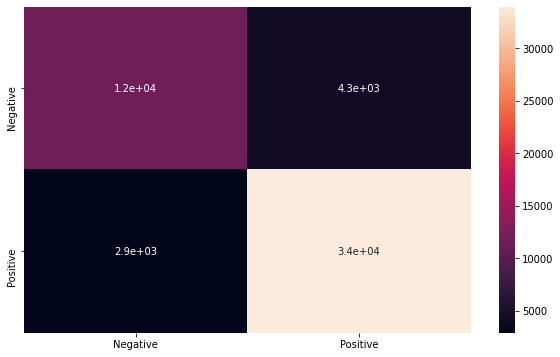

In [0]:
plotConfusionMatrix(test_data["sentiment"], test_data["Actual Output"])

In [0]:
model.save(model_name+'.h5')